reference 1: https://www.kaggle.com/code/raphaelekete/cluster-analysis-of-breast-cancer-data-set 
reference 2: https://blog.csdn.net/FAICULTY/article/details/79430164

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
import time

In [4]:
def cal_euclidean(p1, p2):
    sum = 0
    for x1, x2 in zip(p1, p2):
        sum += (x1 - x2) ** 2
    sum **= 0.5
    return sum

class myDBSCAN:
    def __init__(self, eps, min_samples):
        self.cores = []  # used to draw filled cycles or empty cycles
        self.labels_ = None
        self.orders = None  # used to show the order of each point
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, dataset):
        n = np.shape(dataset)[0]
        neibors = {}
        cores = []
        for i in range(n):
            i_samples = []
            for j in range(n):
                if cal_euclidean(dataset[i], dataset[j]) < self.eps:
                    i_samples.append(j)
            # it couldn't be ">=" since i_samples have already included "i" itself
            if len(i_samples) > self.min_samples:
                neibors[i] = i_samples
                cores.append(i)
        self.cores = cores.copy()
        clustered = [0] * n
        self.orders = [0] * n
        num = 0
        order = 1
        while len(cores) > 0:
            num += 1
            rand = random.choice(cores)
            queue = [rand]
            while len(queue) > 0:
                q = queue[0]
                queue.remove(q)
                clustered[q] = num  # the point "rand" is at "num"th cluster
                self.orders[q] = order  # record the order in which the points are visited
                order += 1
                if cores.count(q):
                    cores.remove(q)
                    for i in neibors[q]:
                        if clustered[i] == 0:
                            queue.append(i)
        self.labels_ = clustered
        return clustered

In [5]:
start_time = time.time()
# preproccess
data = pd.read_csv('data.csv')
data = data.drop(['id','Unnamed: 32'],axis = 1)
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})
scaler = StandardScaler()
X = scaler.fit_transform(data.drop('diagnosis', axis=1))

In [6]:
# Vary the eps and min_samples hyperparameter
eps_list = np.linspace(2, 10, num=30)
min_sample_list = np.arange(3 , 30)

# Set the eps/minimum number of samples to a fixed value
eps = 2.9
min_samples = 24

# Set the number of runs
num_runs = 10

# Initialize arrays to store the performance metrics
eps_silhouette_scores = np.zeros((len(eps_list), num_runs))
eps_nmi_scores = np.zeros((len(eps_list), num_runs))
min_sample_silhouette_scores = np.zeros((len(min_sample_list), num_runs))
min_sample_nmi_scores = np.zeros((len(min_sample_list), num_runs))

sum_silhouette_socres = 0
sum_min_sample_nmi_socres = 0
num = 0

In [7]:
# Run DBSCAN to get the average
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, data['diagnosis'], test_size = 0.1)
    dbscan = myDBSCAN(min_samples=24, eps = 2.9)
    dbscan.fit(X_train)
    labels = dbscan.labels_
    if 1 < len(np.unique(labels)) < 24:
        sum_silhouette_socres += silhouette_score(X_train, labels)
        sum_min_sample_nmi_socres += normalized_mutual_info_score(y_train, labels)
        num += 1

print("Average Silhouette Coefficient: " + str(sum_silhouette_socres / num))
print("Average Normalized Mutual Info Score: " + str(sum_min_sample_nmi_socres / num))

Average Silhouette Coefficient: 0.24702757516694435
Average Normalized Mutual Info Score: 0.2896434656226484


In [8]:
# Run DBSCAN with different eps values and random seeds
for i, e in enumerate(eps_list):
    for j in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, data['diagnosis'], test_size=0.1)
        # Set a different random seed for each run
        dbscan = myDBSCAN(min_samples=min_samples, eps=e)
        dbscan.fit(X_train)
        labels = dbscan.labels_
        if 1 < len(np.unique(labels)) < min_samples:
            # Compute the performance metrics
            eps_silhouette_scores[i, j] = silhouette_score(X_train, labels)
            eps_nmi_scores[i, j] = normalized_mutual_info_score(y_train, labels)

In [9]:
# Run DBSCAN with different min_sample values and random seeds
for i, m in enumerate(min_sample_list):
    for j in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, data['diagnosis'], test_size=0.1)
        # Set a different random seed for each run
        dbscan = myDBSCAN(min_samples=m, eps=eps)
        dbscan.fit(X_train)
        labels = dbscan.labels_
        if 1 < len(np.unique(labels)) < m:
            # Compute the performance metrics
            min_sample_silhouette_scores[i, j] = silhouette_score(X_train, labels)
            min_sample_nmi_scores[i, j] = normalized_mutual_info_score(y_train, labels)

In [10]:
# Compute the mean and standard deviation of the performance metrics across runs
eps_silhouette_mean = np.mean(eps_silhouette_scores, axis=1)
eps_silhouette_std = np.std(eps_silhouette_scores, axis=1)
eps_nmi_mean = np.mean(eps_nmi_scores, axis=1)
eps_nmi_std = np.std(eps_nmi_scores, axis=1)

min_sample_silhouette_mean = np.mean(min_sample_silhouette_scores, axis=1)
min_sample_silhouette_std = np.std(min_sample_silhouette_scores, axis=1)
min_sample_nmi_mean = np.mean(min_sample_nmi_scores, axis=1)
min_sample_nmi_std = np.std(min_sample_nmi_scores, axis=1)

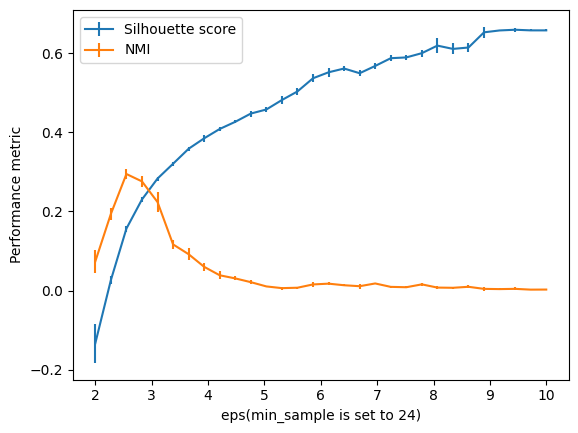

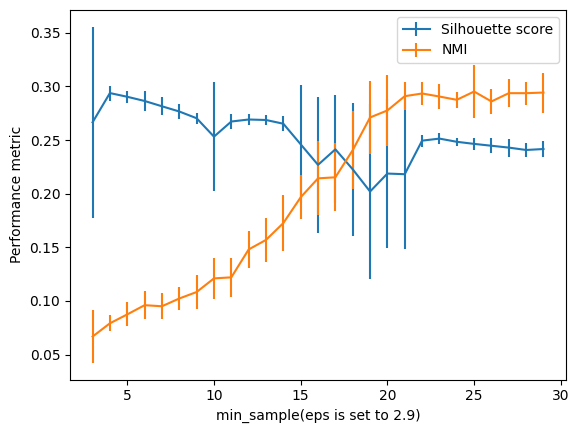

In [11]:
# Plot the performance metrics when min_sample is fixed
eps_fig, eps_ax = plt.subplots()
eps_ax.errorbar(eps_list, eps_silhouette_mean, yerr=eps_silhouette_std, label='Silhouette score')
eps_ax.errorbar(eps_list, eps_nmi_mean, yerr=eps_nmi_std, label='NMI')
eps_ax.set_xlabel('eps(min_sample is set to ' + str(min_samples) + ')')
eps_ax.set_ylabel('Performance metric')
eps_ax.legend()
plt.show()

# Plot the performance metrics when eps is fixed
min_sample_fig, min_sample_ax = plt.subplots()
min_sample_ax.errorbar(min_sample_list, min_sample_silhouette_mean, yerr=min_sample_silhouette_std, label='Silhouette score')
min_sample_ax.errorbar(min_sample_list, min_sample_nmi_mean, yerr=min_sample_nmi_std, label='NMI')
min_sample_ax.set_xlabel('min_sample(eps is set to ' + str(eps) + ')')
min_sample_ax.set_ylabel('Performance metric')
min_sample_ax.legend()
plt.show()

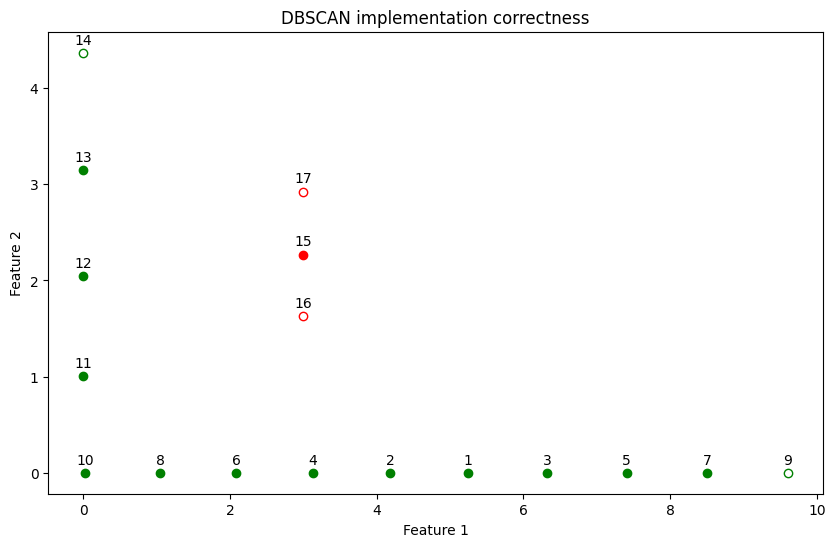

In [13]:
# implementation correctness
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

dataic = pd.read_csv('implementation_correctness_dataset.csv')
Xic = dataic.drop('Class/Cluster', axis='columns').values

dbsic = myDBSCAN(eps=1.25, min_samples=2)
dbs_predic = dbsic.fit(Xic)
# Scatter plot
plt.figure(figsize=(10, 6))
for i, point in enumerate(Xic):
    cluster = dbs_predic[i]
    if dbsic.cores.count(i):
        # draw filled circles
        plt.plot(point[0], point[1], 'o', markeredgecolor=colors[cluster],markerfacecolor=colors[cluster])
    else:
        # draw empty circles
        plt.plot(point[0], point[1], 'o', markeredgecolor=colors[cluster],markerfacecolor="None")
    # show the order on top of each point
    plt.text(point[0], point[1] + 0.06, dbsic.orders[i], ha='center', va='bottom')
plt.title('DBSCAN implementation correctness')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [14]:
end_time = time.time()
run_time = end_time - start_time
print("run time:" + str(run_time))

run time:850.965441942215
